# Merixstudio tweet sentiment analysis

## Initial notebook settings

In [1]:
# Imports
import re
import pandas as pd

from typing import List
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tqdm.notebook import tqdm
from wordcloud import WordCloud

from matplotlib import pyplot as plt

In [2]:
# Constants
RANDOM_STATE = 42  # Answer to Everything
DATA_LOCATION = "data/training.1600000.processed.noemoticon.csv"
STOP_WORDS = set(stopwords.words("english"))
STEMMER = PorterStemmer()
LEMMATIZER = WordNetLemmatizer()

## Preparing data for Machine Learning

The sentiment analysis dataset was downloaded from Kaggle and is available here:
- [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/kazanova/sentiment140)

In [3]:
# Load the twitter sentiment dataset
tweets = pd.read_csv(
    DATA_LOCATION,
    encoding="ISO-8859-1",
    header=None,
    names=(
        "target",
        "tweet_id",
        "date",
        "flag",
        "user",
        "text",
    ),
)
tweets.sample(10)

,target,tweet_id,date,flag,user,text
762881,0,2298077108,Tue Jun 23 11:13:41 PDT 2009,NO_QUERY,cameo1172,@donniewahlberg BUT - you don't like 'repeats...
1499160,4,2070749386,Sun Jun 07 18:14:01 PDT 2009,NO_QUERY,kaya93,Watchin the LAKERs
1357841,4,2048094279,Fri Jun 05 14:39:15 PDT 2009,NO_QUERY,Juicebox275,A split is so gay..for my jj people a split is...
349748,0,2017335190,Wed Jun 03 08:13:25 PDT 2009,NO_QUERY,mthfcknALYSSA,Starbucks coffee is getting to my stomach now....
1127762,4,1975248573,Sat May 30 14:45:35 PDT 2009,NO_QUERY,tomwebster,@juliarosen I'm totally using that ploy.
1531235,4,2177987170,Mon Jun 15 07:01:25 PDT 2009,NO_QUERY,Lamayma,@charnets Fancy is right. That's all it is.
1425412,4,2059047765,Sat Jun 06 16:08:34 PDT 2009,NO_QUERY,thejordaneffect,talking to her brown bear.
1310342,4,2013286832,Tue Jun 02 22:19:13 PDT 2009,NO_QUERY,rach___,oooh man just want the weekend alll over again!!
1393132,4,2053481453,Sat Jun 06 04:42:33 PDT 2009,NO_QUERY,erizaputri,The end of Gossip Girl makes me fall in love w...
1072335,4,1966556822,Fri May 29 17:59:10 PDT 2009,NO_QUERY,jords_,@handandface lol thanks


It is interesting to see that the authors of the dataset describe `3` values for the `target` of a tweet:
- `0` - negative, 
- `2` - neutral,
- `4` - positive.

If we check the actual counts of the dataset, we only have the following:

In [4]:
tweets.target.value_counts()

0    800000
4    800000
Name: target, dtype: int64

We will clean up the columns that won't be useful for us a bit and prepare the data for machine learning.

In [5]:
# Remove unused columns
tweets = tweets[["target", "text"]]

In [6]:
# Map target values to 0 and 1
tweets["target"].replace({4: 1}, inplace=True)

In [7]:
# We will define this method as it will be useful later
def create_tweet_tokens(text: str) -> List[str]:
    # Clean mentions, punctuation, etc.
    tokens = re.sub(
        "(&gt;)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(\d+)",
        " ",
        text.lower(),
    ).split()

    # Remove english stop words
    tokens = [token for token in tokens if token not in STOP_WORDS]

    # Stem words (change to root form)
    tokens = [STEMMER.stem(token) for token in tokens]

    # Lemmatize words (get actual word for the language)
    tokens = [LEMMATIZER.lemmatize(token) for token in tokens]

    return tokens


text_tokens = []
for text in tqdm(tweets["text"], desc="Processing rows"):
    tokens = create_tweet_tokens(text)
    text_tokens.append(tokens)
tweets["text_tokens"] = text_tokens

tweets.sample(10)

Processing rows:   0%|          | 0/1600000 [00:00<?, ?it/s]

,target,text,text_tokens
243225,0,OMG DIS SHIT CRAZY.. I REALLY MISS MY DOG LIKE...,"[omg, di, shit, crazi, realli, miss, dog, like..."
463089,0,@corbentmil you are so mean.,[mean]
688052,0,Well I think I have got the stupid sick bug th...,"[well, think, got, stupid, sick, bug, go, round]"
1329243,1,@gwyn007 @waz7710 no no really its ok! u tr...,"[realli, ok, u, tri, em, u, see, work, doesnt,..."
1309755,1,hitting the hay! grr! stupid finals in the mor...,"[hit, hay, grr, stupid, final, morn, good, night]"
902386,1,@bayanijovan everything is near here in SG! bu...,"[everyth, near, sg, point, sana, hindi, sa, ju..."
1450460,1,"@NicholasTheWord music for the most part, i'll...","[music, part, mail, stuff, back, belgium, cooool]"
787835,0,feeling quite jealous. my brother has a seat o...,"[feel, quit, jealou, brother, seat, centr, cou..."
302489,0,is pretty hurt... just need you here.. and you...,"[pretti, hurt, need, usual]"
1178807,1,@SilknPearls yes this is cool i get to meet ne...,"[ye, cool, get, meet, new, gf, peep, cgft]"


Before we jump down into machine learning, let's see how the word cloud of this set looks like!

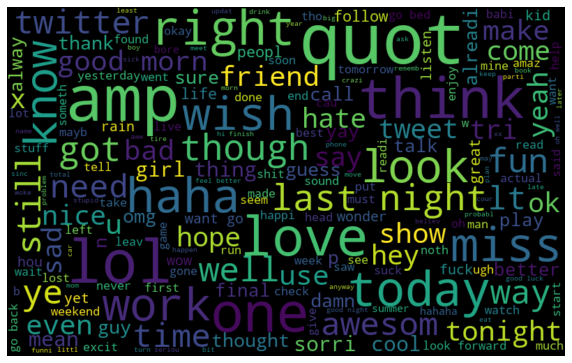

In [8]:
# Join all the words!
all_words = " ".join([" ".join(token) for token in tweets["text_tokens"]])

# Create a word cloud
wordcloud = WordCloud(
    width=800,
    height=500,
    random_state=RANDOM_STATE,
    max_font_size=100,
).generate(all_words)

# And display it!
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Machine Learning

## Gathering Merixstudio tweets

## Sentiment analysis of Merixstudio tweets